## Labeling

This pipeline labels each cluster.

In [1]:
from pandas import read_pickle, DataFrame
import geopandas
import pickle
import random
import numpy as np
from wikiparse import pipeline_utils as utils

In [2]:
from pathlib import Path
from wikiparse import config

xml_filename = config.xml
scratch_folder = Path(config.folder)

In [3]:
import time
pipeline_start = time.time()

In [4]:
gdf = read_pickle(scratch_folder/'gdf_clusters.pkl')
gdf['tf_idf'] = gdf.tf_idf.astype('float64')

In [5]:
gdf.sample(5)

word tf                     article      df    tf_idf  \
12007105  geographical  1                   Hinksland    5314  0.000188   
15027457      building  2  Coughanour Apartment Block  108310  0.000018   
1918673     compliment  1                 Calverstown      70  0.014286   
19769052          more  1                      Arksey   99816  0.000010   
18340572      category  1          Mehdiabad, Semirom  449186  0.000002   

                             geometry         lon        lat  cluster_193  \
12007105   POINT (-28.31667 71.71667)  -28.316667  71.716667           71   
15027457  POINT (-116.93444 44.07583) -116.934444  44.075833          186   
1918673     POINT (-6.79797 53.08252)   -6.797970  53.082520          136   
19769052    POINT (-1.12560 53.55530)   -1.125600  53.555300          191   
18340572    POINT (51.37361 31.68833)   51.373611  31.688333          169   

          cluster_4000  cluster_25000  cluster_7  
12007105          2821            246          0  
15027457          3347           4267          0  
1918673           2035          15961          5  
19769052           389          18444          5  
18340572           157          22862          2

In [6]:
def label_filter(label):
    return len(label) > 1

In [7]:
def get_center(gdf):
    geom  = gdf.sample(min(len(gdf), 1000)).geometry
    return (geom.map(lambda x: x.x).mean(), geom.map(lambda x: x.y).mean())

Experimenting in choosing the label for an entire continent so it's not hyper-local but also not hyper-widespread; I'll need to define some kind of multi-parameter optimization between the 'ones' and 'tf_idf' columns.

Test whether this new `combined_score` produced better labels for the continents.

What I want to do: for each possible cluster, get a label. The label is defined as the word in that cluster which returns the maximum from the `combined_score` function, which is a function of summed tf-idf scores and the count of occurances in the article. So, if the word 'Seattle' occurs twice in a given cluster with tf-idf scores of 1 and .5, then the `combined_score` will be a function of 1.5 and 2. 

~~multiplying them together to give a score of 3. This seems to strike the right balance between weighting extremely rare but hyper-local labels (eg, we don't want to name North America after a train station in San Francisco with a unique name) and pervasive but non-descriptive labels (it would be pretty boring if the continents were all named words like 'in', 'with', and 'page').~~

Now I just need to grab the top result for each possible `cluster_7` value.

In [8]:
start = time.time()
cluster_labels = {}
centers = {}
already_used = set()
gdf['ones'] = 1

for zoom_level in ['7', '193', '4000', '25000']:
# for zoom_level in ['7', '193', '4000']:
    cluster_labels[zoom_level] = {}
    centers[zoom_level] = {}
#     no_duplicates = (zoom_level in ['7','193', '4000'])
    no_duplicates = True
    
    cluster_name = 'cluster_' + zoom_level

    for cluster_num in range(0,int(zoom_level)):
        idx = 0
        cluster = gdf[gdf[cluster_name] == cluster_num]
        most_common_words = cluster.groupby(by='word').sum()
        # this score de-emphasizes extremely rare words dominating the labels
        most_common_words['score'] = most_common_words.tf_idf * np.log(most_common_words.ones)
        most_common_words.sort_values(by='score', ascending=False, inplace=True)
        label = most_common_words.index[0]
        if no_duplicates:
            while idx < min(len(most_common_words)-1,5) and (label in already_used or not label_filter(label)):
                idx += 1
                label = most_common_words.index[idx]
            if idx == min(len(most_common_words),5): 
                idx = random.randint(0, min(len(most_common_words.index), 5))
                label = most_common_words.index[idx]
        if no_duplicates:
            already_used.add(label)
        cluster_labels[zoom_level][int(cluster_num)] = label
        centers[zoom_level][int(cluster_num)] = get_center(cluster)
        
    print('done with', zoom_level, round((time.time()-start)/60, 1), 'minutes so far')
print(cluster_labels['7'])

done with 7 0.4 minutes so far
done with 193 1.0 minutes so far
done with 4000 8.2 minutes so far
done with 25000 28.3 minutes so far
{0: 'honeydew', 1: 'chile', 2: 'penang', 3: 'woy', 4: 'scar', 5: 'swiss', 6: 'arusha'}


In [9]:
def save_pickle(fname, obj):
    with open(fname, 'wb') as f:
        f.write(pickle.dumps(obj))
save_pickle(scratch_folder/'cluster_labels.pkl', cluster_labels)
save_pickle(scratch_folder/'centers.pkl', centers)

In [10]:
for zoom_level in ['7', '193', '4000', '25000']:
    labels = []
    for idx,word in cluster_labels[zoom_level].items():
        labels.append((word.capitalize(), centers[zoom_level][idx][1], centers[zoom_level][idx][0]))
    DataFrame(labels, columns=['label', 'lat', 'lon']).to_csv(scratch_folder/f'labels_{zoom_level}.csv')

I'm using the "most distinctive" method, where I sum the TF-IDF scores of each word and choose the one with the highest. So, if a word occurs in only a few articles in that group but each time the signal or TF-IDF score is high, it could end up being the label for the entire region. This leads to extremely obscure labels for a lot of regions, some of which you might know if you know the area and some that leave you scratching your head. The best approach--the one most likely to lead to an enjoyable experience while perusing this map--is probably a mixture of both. Commonest-word works best at the country level, and I'll probably use most-distinctive for smaller regions where you might expect there to be super obscure names anyway.

Not sure what to do about the continent names, but I do like the most-distinctive labels better. I mean, Dreamland? Kashoggi?! (That one is too grisly for my taste)On the other hand, Orania, Armbrust, Canalec, Omak, and Lomp. Pretty sure it's just choosing the first words that don't appear anywhere else in the dataset. At least each one is interesting, unlike the other list: Unincorporated, California, Iran, India, Queensland, Antarctic, and Commune. I did get a laugh out of the last one, though.

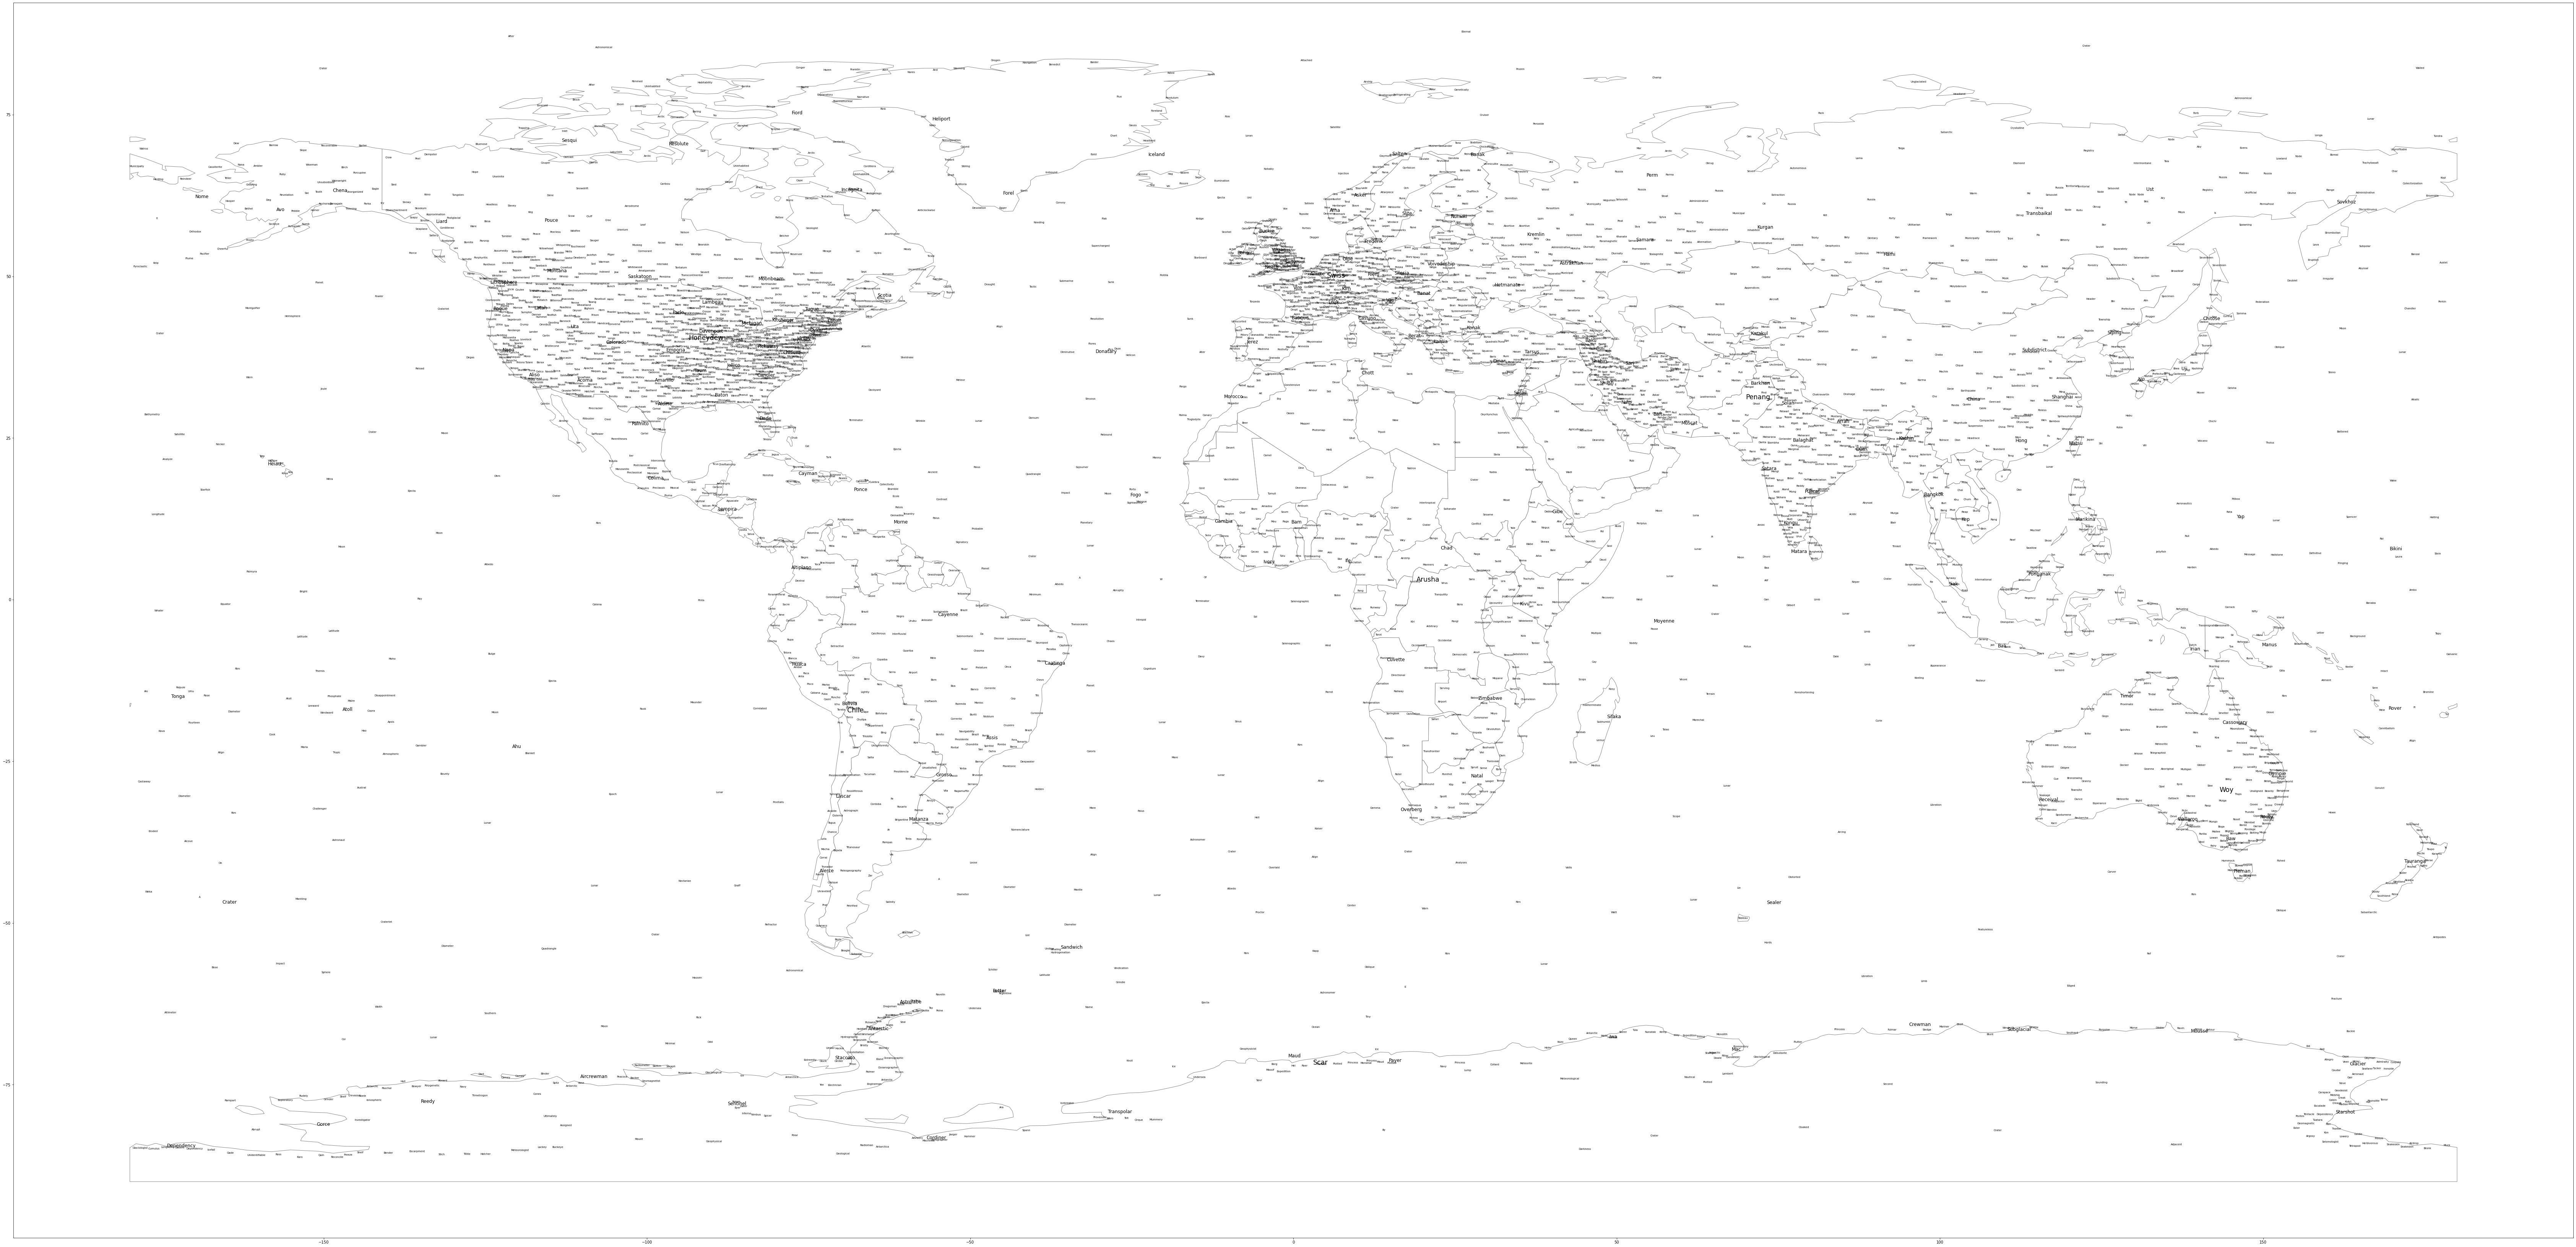

In [11]:
def plot_cluster_labels(cluster_dict, centers, fname=None, figsize=(120,80)):
    import matplotlib.pyplot as plt
    world = utils.get_world_bg()

    ax = world.plot(color='white', edgecolor='gray', figsize=figsize)
    for zoom_level in cluster_dict.keys():  
        if zoom_level == '25000': continue
        for num,word in cluster_dict[zoom_level].items():
            size = {'7':'xx-large', '193':'large', '4000':'x-small'}[zoom_level]
            try:
                point = centers[zoom_level][num]
            except:
                print(num, "not found in centers at", zoom_level, word)
            ax = utils.plot_text(ax, word.capitalize(), point, size)
    if fname:
        plt.savefig(fname)

plot_cluster_labels(cluster_labels, centers, fname=scratch_folder/'test_map.png', figsize=(120,80))

In [12]:
took = time.time() - pipeline_start
if took < 60:
    print("pipeline took", round(took, 2), "seconds")
elif took < 3600:
    print("pipeline took", round(took/60, 2), "minutes")
else:
    print("pipeline took", round(took/60/60, 2), "hours")

pipeline took 29.19 minutes


In [13]:
def speak(text):
    from IPython.display import Javascript as js, clear_output
    # Escape single quotes
    text = text.replace("'", r"\'")
    display(js(f'''
    if(window.speechSynthesis) {{
        var synth = window.speechSynthesis;
        synth.speak(new window.SpeechSynthesisUtterance('{text}'));
    }}
    '''))
    # Clear the JS so that the notebook doesn't speak again when reopened/refreshed
    clear_output(False)
speak("done")